In [ ]:
import os
import os.path as op
import numpy as np
import pandas as pd

import nibabel as nib
from nimare.transforms import p_to_z

import nilearn
from nilearn import plotting
from nilearn import datasets
import nilearn.reporting
from nilearn.image import threshold_img

from nilearn.maskers import NiftiSpheresMasker

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_dir = "./dset"
age_dir = op.join(data_dir, "age-effect5-21old/habenula")

In [ ]:
sns.set_theme(color_codes=True)

In [ ]:
# get peaks
brik_fn = op.join(age_dir, "sub-group_task-rest_desc-agehabenula_briks+tlrc.BRIK")
table_fn = op.join(age_dir, "sub-group_task-rest_desc-Agehabenula_table.txt")
nii_1s_fn = op.join(age_dir, "sub-group_task-rest_desc-ageDiff_zmap.nii.gz")
cluster_fn = op.join(age_dir, "clustsim", "clustsim_out.NN3_bisided.1D")

column_names = [".10000", ".05000", ".02000", ".01000"]
cluster_df = pd.read_table(
    cluster_fn, skiprows=8, delim_whitespace=True, names=column_names
)
cluster_df = cluster_df.reset_index()
cluster_df.rename(columns={"index": "pthr"}, inplace=True)
print(cluster_df)

cmap = "cool"
brik_idx = [11]
nii_fns = [nii_1s_fn]
tests = ["1s"]
alpha = ".10000"
pthrs = [0.0050]

cohen_thresh = 0

data_df = pd.read_csv(table_fn, sep="\t")
n_sub = data_df.groupby("group").size().sum()
n_sub_1, n_sub_2 = data_df.groupby("group").size().values

for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    convert = f"3dAFNItoNIFTI \
        -prefix {nii_fn} \
        {brik_fn}[{brik_i}]"
    os.system(convert)

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    info = nii_img.get_fdata()

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)
    print(clust_ext, pthr, z_thresh)

    clusters = nilearn.reporting.get_clusters_table(
        nii_thr_img, z_thresh, two_sided=True
    )
    print(clusters)  # coordinates are same as affine of input (MNI)

In [ ]:
from nilearn import datasets
from nilearn.image import load_img
from nilearn.input_data import NiftiLabelsMasker
import numpy as np

# Load the Juelich atlas
'''juelich_atlas = datasets.fetch_atlas_juelich("maxprob-thr0-1mm")
atlas_filename = juelich_atlas.maps
atlas_labels = juelich_atlas.labels'''

# Load the Harvard-Oxford atlas
harvard_oxford_atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-1mm")
atlas_filename = harvard_oxford_atlas.maps
atlas_labels = harvard_oxford_atlas.labels

# Load the atlas image
atlas_img = load_img(atlas_filename)


# Function to find the region for a given coordinate
def find_region(coord):
    # Transform MNI coordinates to voxel indices
    voxel_indices = np.round(
        nib.affines.apply_affine(np.linalg.inv(atlas_img.affine), coord)
    ).astype(int)
    # Get the label index for the voxel
    label_idx = atlas_img.get_fdata()[tuple(voxel_indices)]
    region_name = (
        atlas_labels[int(label_idx)]
        if int(label_idx) < len(atlas_labels)
        else "Unknown"
    )
    return region_name


# Extract the coordinates from the clusters table and map to regions
def map_clusters_to_regions(clusters_df):
    coordinates = clusters_df[["X", "Y", "Z"]].values
    regions = [find_region(coord) for coord in coordinates]
    clusters_df["Region"] = regions
    return clusters_df


# Iterate over your clusters and map to regions
for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    convert = f"3dAFNItoNIFTI -prefix {nii_fn} {brik_fn}[{brik_i}]"
    os.system(convert)

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    info = nii_img.get_fdata()

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)
    print(clust_ext, pthr, z_thresh)

    clusters = nilearn.reporting.get_clusters_table(nii_thr_img, stat_threshold=z_thresh, two_sided=True)
    clusters_with_regions = map_clusters_to_regions(clusters)
    print(clusters_with_regions)

    output_filename = op.join(age_dir, f"clusters_with_subregions_{test}_pthr_{pthr}.csv")
    clusters_with_regions.to_csv(output_filename, index=False)
    print(f"Saved clusters with regions to {output_filename}")

In [ ]:
import os
import subprocess
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn.image import threshold_img
from nilearn.reporting import get_clusters_table


# Function to execute the AFNI whereami command and parse its output
def find_region(coord):
    # Format the coordinates properly for the whereami command
    coord_str = f"{coord[0]} {coord[1]} {coord[2]}"
    # Command to query AFNI's whereami
    whereami_cmd = f"whereami [{coord_str}] -atlas MNI_Glasser_HCP_v1.0 -classic"
    try:
        result = subprocess.run(
            whereami_cmd,
            shell=True,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        output = result.stdout
        # Print the full output for debugging purposes
        print(f"whereami output for {coord}:")
        print(output)
        # Parse the output to extract the region name
        for line in output.split("\n"):
            if "Focus point (LPI)" in line:
                parts = line.split()
                if len(parts) > 3:
                    return parts[3]  # Extract the region name
        return "Unknown"
    except subprocess.CalledProcessError as e:
        print(
            f"Error running whereami command: {e}\nOutput: {e.output}\nError: {e.stderr}"
        )
        return "Unknown"


# Extract the coordinates from the clusters table and map to regions
def map_clusters_to_regions(clusters_df):
    coordinates = clusters_df[["X", "Y", "Z"]].values
    regions = [find_region(coord) for coord in coordinates]
    clusters_df["Region"] = regions
    return clusters_df


# Iterate over your clusters and map to regions
for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    convert = f"3dAFNItoNIFTI -prefix {nii_fn} {brik_fn}[{brik_i}]"
    os.system(convert)

    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    info = nii_img.get_fdata()

    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)

    clusters = get_clusters_table(nii_thr_img, stat_threshold=z_thresh, two_sided=True)
    clusters_with_regions = map_clusters_to_regions(clusters)

In [ ]:
# Filter the DataFrame to include only rows where 'Cluster Size (mm3)' is empty
subclusters = clusters[clusters["Cluster Size (mm3)"] == ""]

# Extract the main cluster ID from the 'Cluster ID' column for grouping
subclusters["Main Cluster ID"] = subclusters["Cluster ID"].str.extract(
    r"(\d+)", expand=False
)

# Group by the main cluster ID and extract coordinates
grouped_coordinates = subclusters.groupby("Main Cluster ID").apply(
    lambda df: df[["X", "Y", "Z"]].values.tolist()
)

# Convert the grouped coordinates to a dictionary for easier access
coordinates_dict = grouped_coordinates.to_dict()

# Print the coordinates dictionary
for cluster_id, coords in coordinates_dict.items():
    print(f"Cluster {cluster_id}: {coords}")

In [ ]:
# Get a list of all directories in the base directory
dset = os.listdir(data_dir)

# Filter out only subject directories (assuming they start with 'sub-')
sub_dir = [d for d in dset if d.startswith("sub-")]

# Loop over each subject directory
# on hpc will use partipant.tsv
for subject in sub_dir:
    subject_path = os.path.join(data_dir, subject, "func")

    if os.path.isdir(subject_path):
        print(f"Processing subject: {subject}")
        subject_brik = op.join(
            subject_path,
            f"{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-norm_bucketREML+tlrc.BRIK",
        )
        subject_nii = op.join(
            subject_path,
            f"{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-norm_bucketREML+tlrc.nii.gz",
        )

        convert = f"3dAFNItoNIFTI \
        -prefix {subject_nii} \
        {subject_brik}[{1}]"
        os.system(convert)

In [ ]:
results = []

for cluster_id, coords in coordinates_dict.items():
    print(f"Cluster {cluster_id}: {coords}")
    for subject in sub_dir:
        subject_path = os.path.join(data_dir, subject, "func")

        if os.path.isdir(subject_path):
            print(f"Processing subject: {subject}")

            subject_nii = nib.load(op.join(
                subject_path,
                f"{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-norm_bucketREML+tlrc.nii.gz",
            ))

            mask_img = datasets.load_mni152_brain_mask(resolution=1)

            for coord in coords:
                print(coord)
                masker = NiftiSpheresMasker([coord], radius = 5, mask_img=mask_img)
                masker = masker.fit_transform(subject_nii)
                print(masker)

                results.append(
                    {"Coordinate": coord, "Subject": subject, "Correlation": masker}
                )

corr_df = pd.DataFrame(results)
print(corr_df)

In [ ]:
for cluster_id, coords in coordinates_dict.items():
    print(f"Cluster {cluster_id}: {coords}")

coords_all = []
for coord_list in coordinates_dict.values():
    coords_all.extend(coord_list)

# Create an empty image
brain_mask = datasets.load_mni152_template(resolution=1)
spheres_img = np.zeros(brain_mask.shape)

# Fill the spheres in the empty image
affine = brain_mask.affine
for coord in coords_all:
    # Convert from MNI coordinates to voxel indices
    x, y, z = nib.affines.apply_affine(np.linalg.inv(affine), coord).astype(int)
    radius = 5  # radius in voxels

    # Create a sphere
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            for k in range(-radius, radius + 1):
                if i**2 + j**2 + k**2 <= radius**2:
                    if (
                        0 <= x + i < spheres_img.shape[0]
                        and 0 <= y + j < spheres_img.shape[1]
                        and 0 <= z + k < spheres_img.shape[2]
                    ):
                        spheres_img[x + i, y + j, z + k] = 1

# Convert the numpy array to a NIfTI image
spheres_nifti = nib.Nifti1Image(spheres_img, affine)

# Plot the spheres on a glass brain
plotting.plot_glass_brain(
    spheres_nifti, display_mode="ortho", colorbar=True, title=f"{radius}mm Spheres for Age Effect", cmap='cool'
)

# Show the plot
plotting.show()

In [ ]:
for cluster_id, coords in coordinates_dict.items():
    print(f"Cluster {cluster_id}: {coords}")

coords_all = []
for coord_list in coordinates_dict.values():
    coords_all.extend(coord_list)

# Create an empty image
brain_mask = datasets.load_mni152_template(resolution=1)
spheres_img = np.zeros(brain_mask.shape)

# Fill the spheres in the empty image
affine = brain_mask.affine
for coord in coords_all:
    # Convert from MNI coordinates to voxel indices
    x, y, z = nib.affines.apply_affine(np.linalg.inv(affine), coord).astype(int)
    radius = 5  # radius in voxels

    # Create a sphere
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            for k in range(-radius, radius + 1):
                if i**2 + j**2 + k**2 <= radius**2:
                    if (
                        0 <= x + i < spheres_img.shape[0]
                        and 0 <= y + j < spheres_img.shape[1]
                        and 0 <= z + k < spheres_img.shape[2]
                    ):
                        spheres_img[x + i, y + j, z + k] = 1

# Convert the numpy array to a NIfTI image
spheres_nifti = nib.Nifti1Image(spheres_img, affine)

# Plot the spheres on a glass brain
plotting.plot_glass_brain(
    spheres_nifti, display_mode="ortho", colorbar=True, title=f"{radius}mm Spheres for Age Effect", cmap='cool'
)

# Show the plot
plotting.show()

In [ ]:
coordinates_dict = {
    "1": [[25.5, -60.5, -6.5], [23.5, -68.5, -2.5], [27.5, -56.5, 7.5]],
    "2": [[-30.5, -54.5, -16.5], [-32.5, -56.5, -6.5], [-20.5, -62.5, -4.5]],
}

corr_df = pd.read_csv(op.join(age_dir, "age-correlation.csv"))
corr_df["Coordinate"] = corr_df["Coordinate"].apply(eval)

for cluster_id, coords in coordinates_dict.items():
    for coord in coords:
        coord_df = corr_df[corr_df["Coordinate"].apply(lambda x: x == coord)]
        print(f"Condensed DataFrame for Coordinate {coord}:")
        print(coord_df)

        g = sns.lmplot(
            data=coord_df,
            x="Age",
            y="Correlation",
            hue="Group",
            markers = ["+", "d"],
            height=7,
        )

        plt.ylim(-0.6, 0.6)
        
        # Add title to the plot
        plt.title(f"Age Effect: {radius}mm Sphere for MNI {coord}")

        # Show the plot
        plt.show()

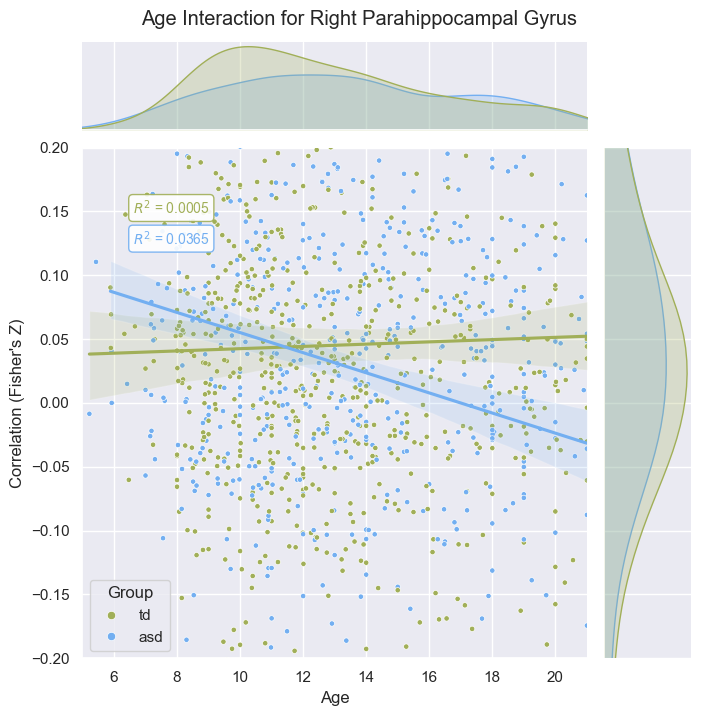

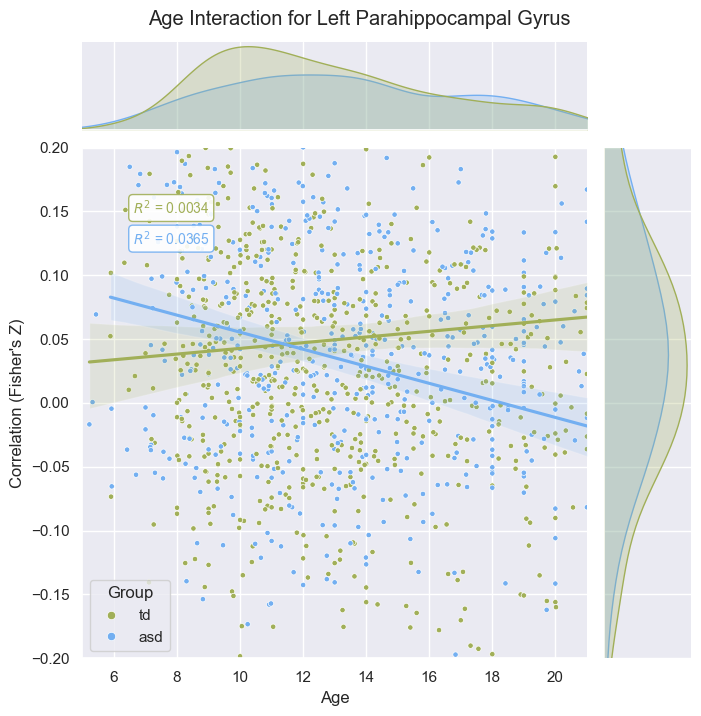

In [36]:
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


coordinates_dict = {
    "1": [[25.5, -60.5, -6.5], [23.5, -68.5, -2.5], [27.5, -56.5, 7.5]],
    "2": [[-30.5, -54.5, -16.5], [-32.5, -56.5, -6.5], [-20.5, -62.5, -4.5]],
}

# Assuming corr_df is your DataFrame loaded from "age-correlation.csv"
corr_df = pd.read_csv(op.join(age_dir, "age-correlation.csv"))

# Group by 'Subject' and 'Cluster', and calculate the mean of 'Correlation'
corr_df_mean = corr_df.groupby(["Subject", "Cluster"], as_index=False)[
    "Correlation"
].mean()
corr_df_mean.rename(columns={"Correlation": "Correlation (Fisher's Z)"}, inplace=True)

# Merge averaged correlations back into the original DataFrame and replace 'Correlation' column
corr_df = pd.merge(corr_df, corr_df_mean, on=["Subject", "Cluster"], how="left")
corr_df["Correlation"] = corr_df[
    "Correlation (Fisher's Z)"
]  # Replace original 'Correlation' with 'Avg_Correlation'
corr_df.drop(
    columns=["Correlation", "Coordinate"], inplace=True
)  # Drop the temporary column

corr_df.drop_duplicates(subset=["Subject", "Cluster"], keep="first", inplace=True)

clusters = [1, 2]
custom_palette = ["#A1AF58", "#73AFF1"]  # Custom palette with colors for each group
custom_palette2 = {"asd": "#A1AF58", "td": "#73AFF1"}  # Map Group names to colors

regions = ["Right Parahippocampal Gyrus", "Left Parahippocampal Gyrus"]

for cluster, region in zip(clusters, regions):
    cluster_df = corr_df[corr_df["Cluster"] == cluster].copy()

    # Create a joint plot
    g = sns.jointplot(
        data=cluster_df,
        x="Age",
        y="Correlation (Fisher's Z)",
        hue="Group",
        palette=custom_palette,
        kind="scatter",
        height=7,
    )

    g.ax_joint.collections[0].set_sizes([15])

    # Adding regression lines for each group
    for i, (group_name, group_data) in enumerate(cluster_df.groupby("Group")):
        sns.regplot(
            x="Age",
            y="Correlation (Fisher's Z)",
            data=group_data,
            scatter=False,
            ax=g.ax_joint,
            color=custom_palette2[group_name],  # Match color with the group
            label=f"Group {group_name}",
        )

        # Calculate R^2 for the current group's regression line
        r_squared = r2(group_data["Age"], group_data["Correlation (Fisher's Z)"])

        # Annotate the plot with the R^2 value, adjusting position for each group
        # Position annotations vertically
        y_offset = i * 0.06  # Adjust vertical spacing between annotations
        # Annotate the plot with the R^2 value, with box around it
        g.ax_joint.annotate(
            f"$R^2$ = {r_squared:.4f}",
            xy=(0.1, 0.9 - y_offset),  # Adjust the position of the annotation (x, y)
            xycoords="axes fraction",
            ha="left",
            va="top",  # Horizontal and vertical alignment
            fontsize=10,
            color=custom_palette2[group_name],  # Match color with the group
            bbox=dict(
                boxstyle="round,pad=0.3",
                edgecolor=custom_palette2[group_name],
                facecolor="white",
                alpha=0.9,
            ),  # Box style and colors
        )

    # Set limits for y-axis
    g.ax_joint.set_ylim(-0.2, 0.2)
    g.ax_joint.set_xlim(5, 21)

    # Add a title to the plot
    g.fig.suptitle(f"Age Interaction for {region}", y=1.02)

    # Display the plot
    plt.show()